# YOLOV8 Instance Segmentation Training and Inference Notebook

This notebook is a simple example of how to pull your exported object detection dataset from Oslo and train a YOLOV8-Seg model using the Ultralytics library.

You need to have the following information to run this notebook:

- `project_identifier`: The identifier of the project you want to use, you can find this on the project page in Oslo.
- `access_token`: Your personal access token, you can find this in your organization settings in Oslo.
- `version`: The version of the dataset you want to use, you can find this on the exports page in Oslo.

It is a good idea to check that you have GPU available first.


In [ ]:
!nvidia-smi

Tue Sep  9 12:10:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip3 install -U ultralytics

import ultralytics as ul

ul.checks()

import os

HOME = os.getcwd()
print("HOME:", HOME)

Ultralytics 8.3.197 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.1/112.6 GB disk)
HOME: /content


In [ ]:
!pip3 install -U oslovision

from oslovision import OsloVision

project_identifier = "[inserthere]"
access_token = "[inserthere]"
dataset_version = "[inserthere]"

oslo = OsloVision(access_token)

# Download dataset
dataset_path = oslo.download_export(project_identifier, dataset_version, HOME)

print("Dataset path:", dataset_path)

Dataset path: /content/number-plates-yolo-seg-1


# Create a Grid of Multiple Images

Visualize 10 random images from the training set in a grid layout to verify that segmentation masks appear correctly.


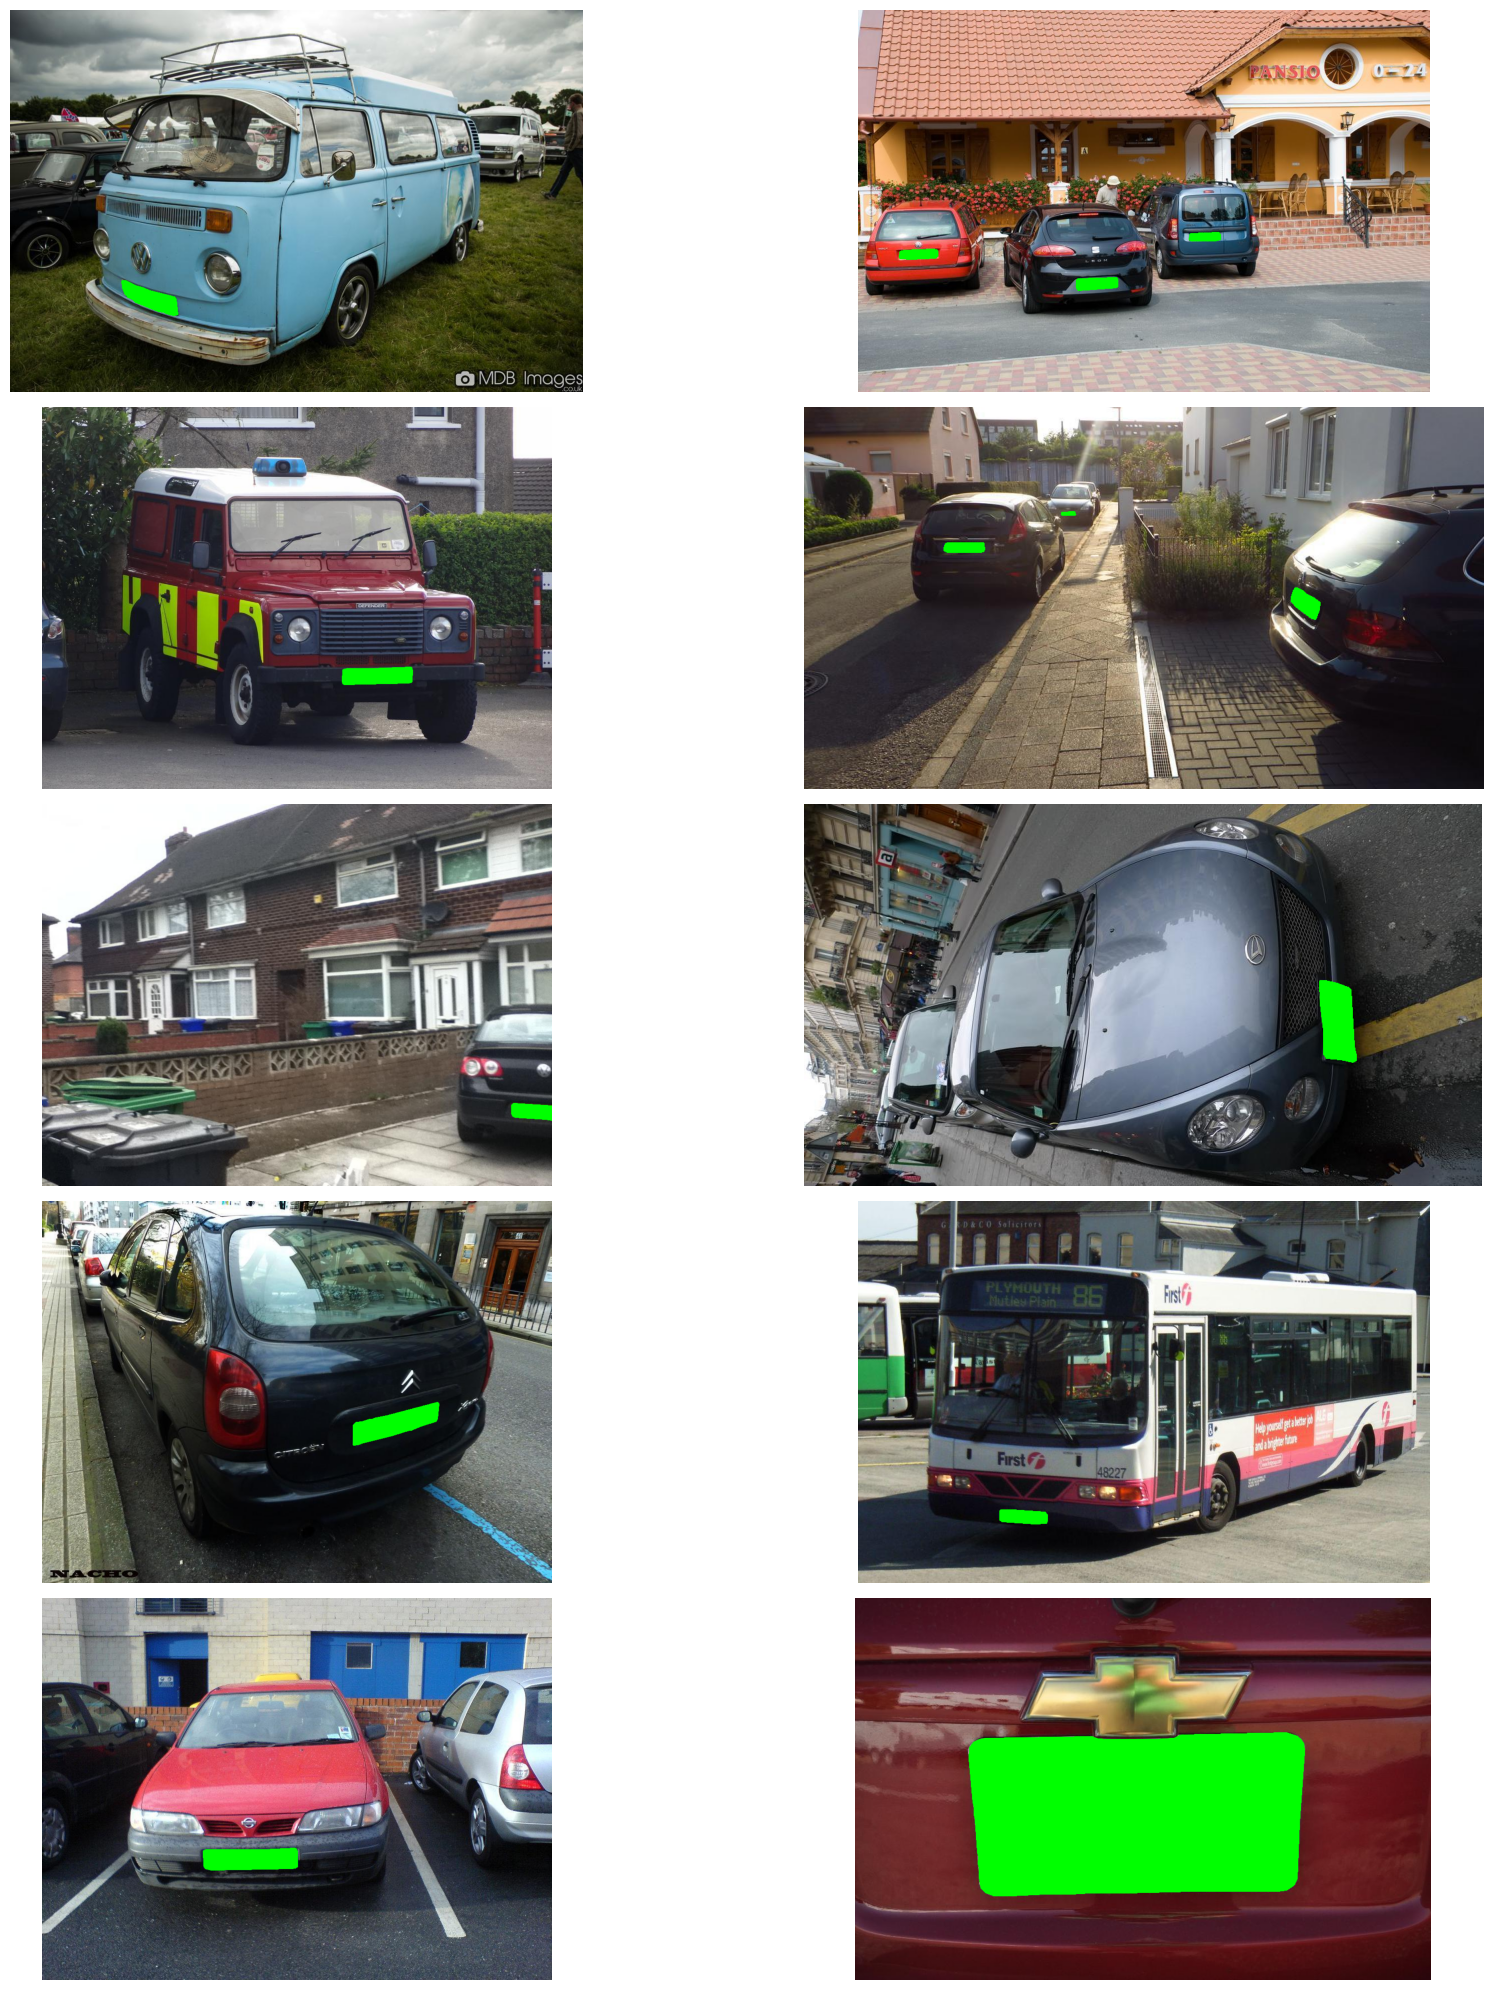

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import yaml
import os


def parse_yolo_segmentation(file_path):
    """
    Parse YOLO segmentation file and return a list of masks.
    """
    masks = []
    with open(file_path, "r") as file:
        for line in file:
            parts = line.strip().split()
            class_id = int(parts[0])
            points = np.array(parts[1:], dtype=np.float32).reshape(-1, 2)
            masks.append((class_id, points))
    return masks


def convert_normalized_coordinates(points, img_width, img_height):
    """
    Convert normalized coordinates to absolute pixel values.
    """
    points[:, 0] *= img_width
    points[:, 1] *= img_height
    return points.astype(np.int32)


def draw_masks_on_image(image, masks):
    """
    Draw segmentation masks on the image.
    """
    img_height, img_width = image.shape[:2]
    for class_id, points in masks:
        points = convert_normalized_coordinates(points, img_width, img_height)
        cv2.polylines(image, [points], isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.fillPoly(image, [points], color=(0, 255, 0, 50))
    return image


# Define the path to the dataset and annotations
images_path = dataset_path + "/train/images"
annotations_path = dataset_path + "/train/labels"

# Get a list of image files and corresponding annotation files
image_files = sorted(
    [
        os.path.join(images_path, f)
        for f in os.listdir(images_path)
        if f.endswith(".jpg")
    ]
)
annotation_files = sorted(
    [
        os.path.join(annotations_path, f)
        for f in os.listdir(annotations_path)
        if f.endswith(".txt")
    ]
)


def visualize_images_with_masks(image_files, annotation_files, num_images=10):
    """
    Visualize a specified number of images with their segmentation masks.
    """
    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        # Load image
        image = cv2.imread(image_files[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load and parse annotation
        masks = parse_yolo_segmentation(annotation_files[i])

        # Draw masks on image
        image_with_masks = draw_masks_on_image(image, masks)

        # Display the image with masks in a grid
        plt.subplot(5, 2, i + 1)
        plt.imshow(image_with_masks)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# Visualize 10 images with their segmentation masks
visualize_images_with_masks(image_files, annotation_files, num_images=10)

In [ ]:
import os

home_dir = os.environ.get("HOME")
print("HOME_DIR:", home_dir)

!rm -rf $home_dir/.config/Ultralytics


HOME_DIR: /root


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8s-seg.pt")
yaml_path = dataset_path + "/data.yaml"

results = model.train(data=yaml_path, epochs=100)


Ultralytics 8.3.197 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/number-plates-yolo-seg-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0

## Visualize training results


In [ ]:
!ls {HOME}/runs/segment/train/

args.yaml			 MaskP_curve.png      train_batch1.jpg
BoxF1_curve.png			 MaskPR_curve.png     train_batch2.jpg
BoxP_curve.png			 MaskR_curve.png      val_batch0_labels.jpg
BoxPR_curve.png			 results.csv	      val_batch0_pred.jpg
BoxR_curve.png			 results.png	      val_batch1_labels.jpg
confusion_matrix_normalized.png  train_batch0.jpg     val_batch1_pred.jpg
confusion_matrix.png		 train_batch1350.jpg  val_batch2_labels.jpg
labels.jpg			 train_batch1351.jpg  val_batch2_pred.jpg
MaskF1_curve.png		 train_batch1352.jpg  weights


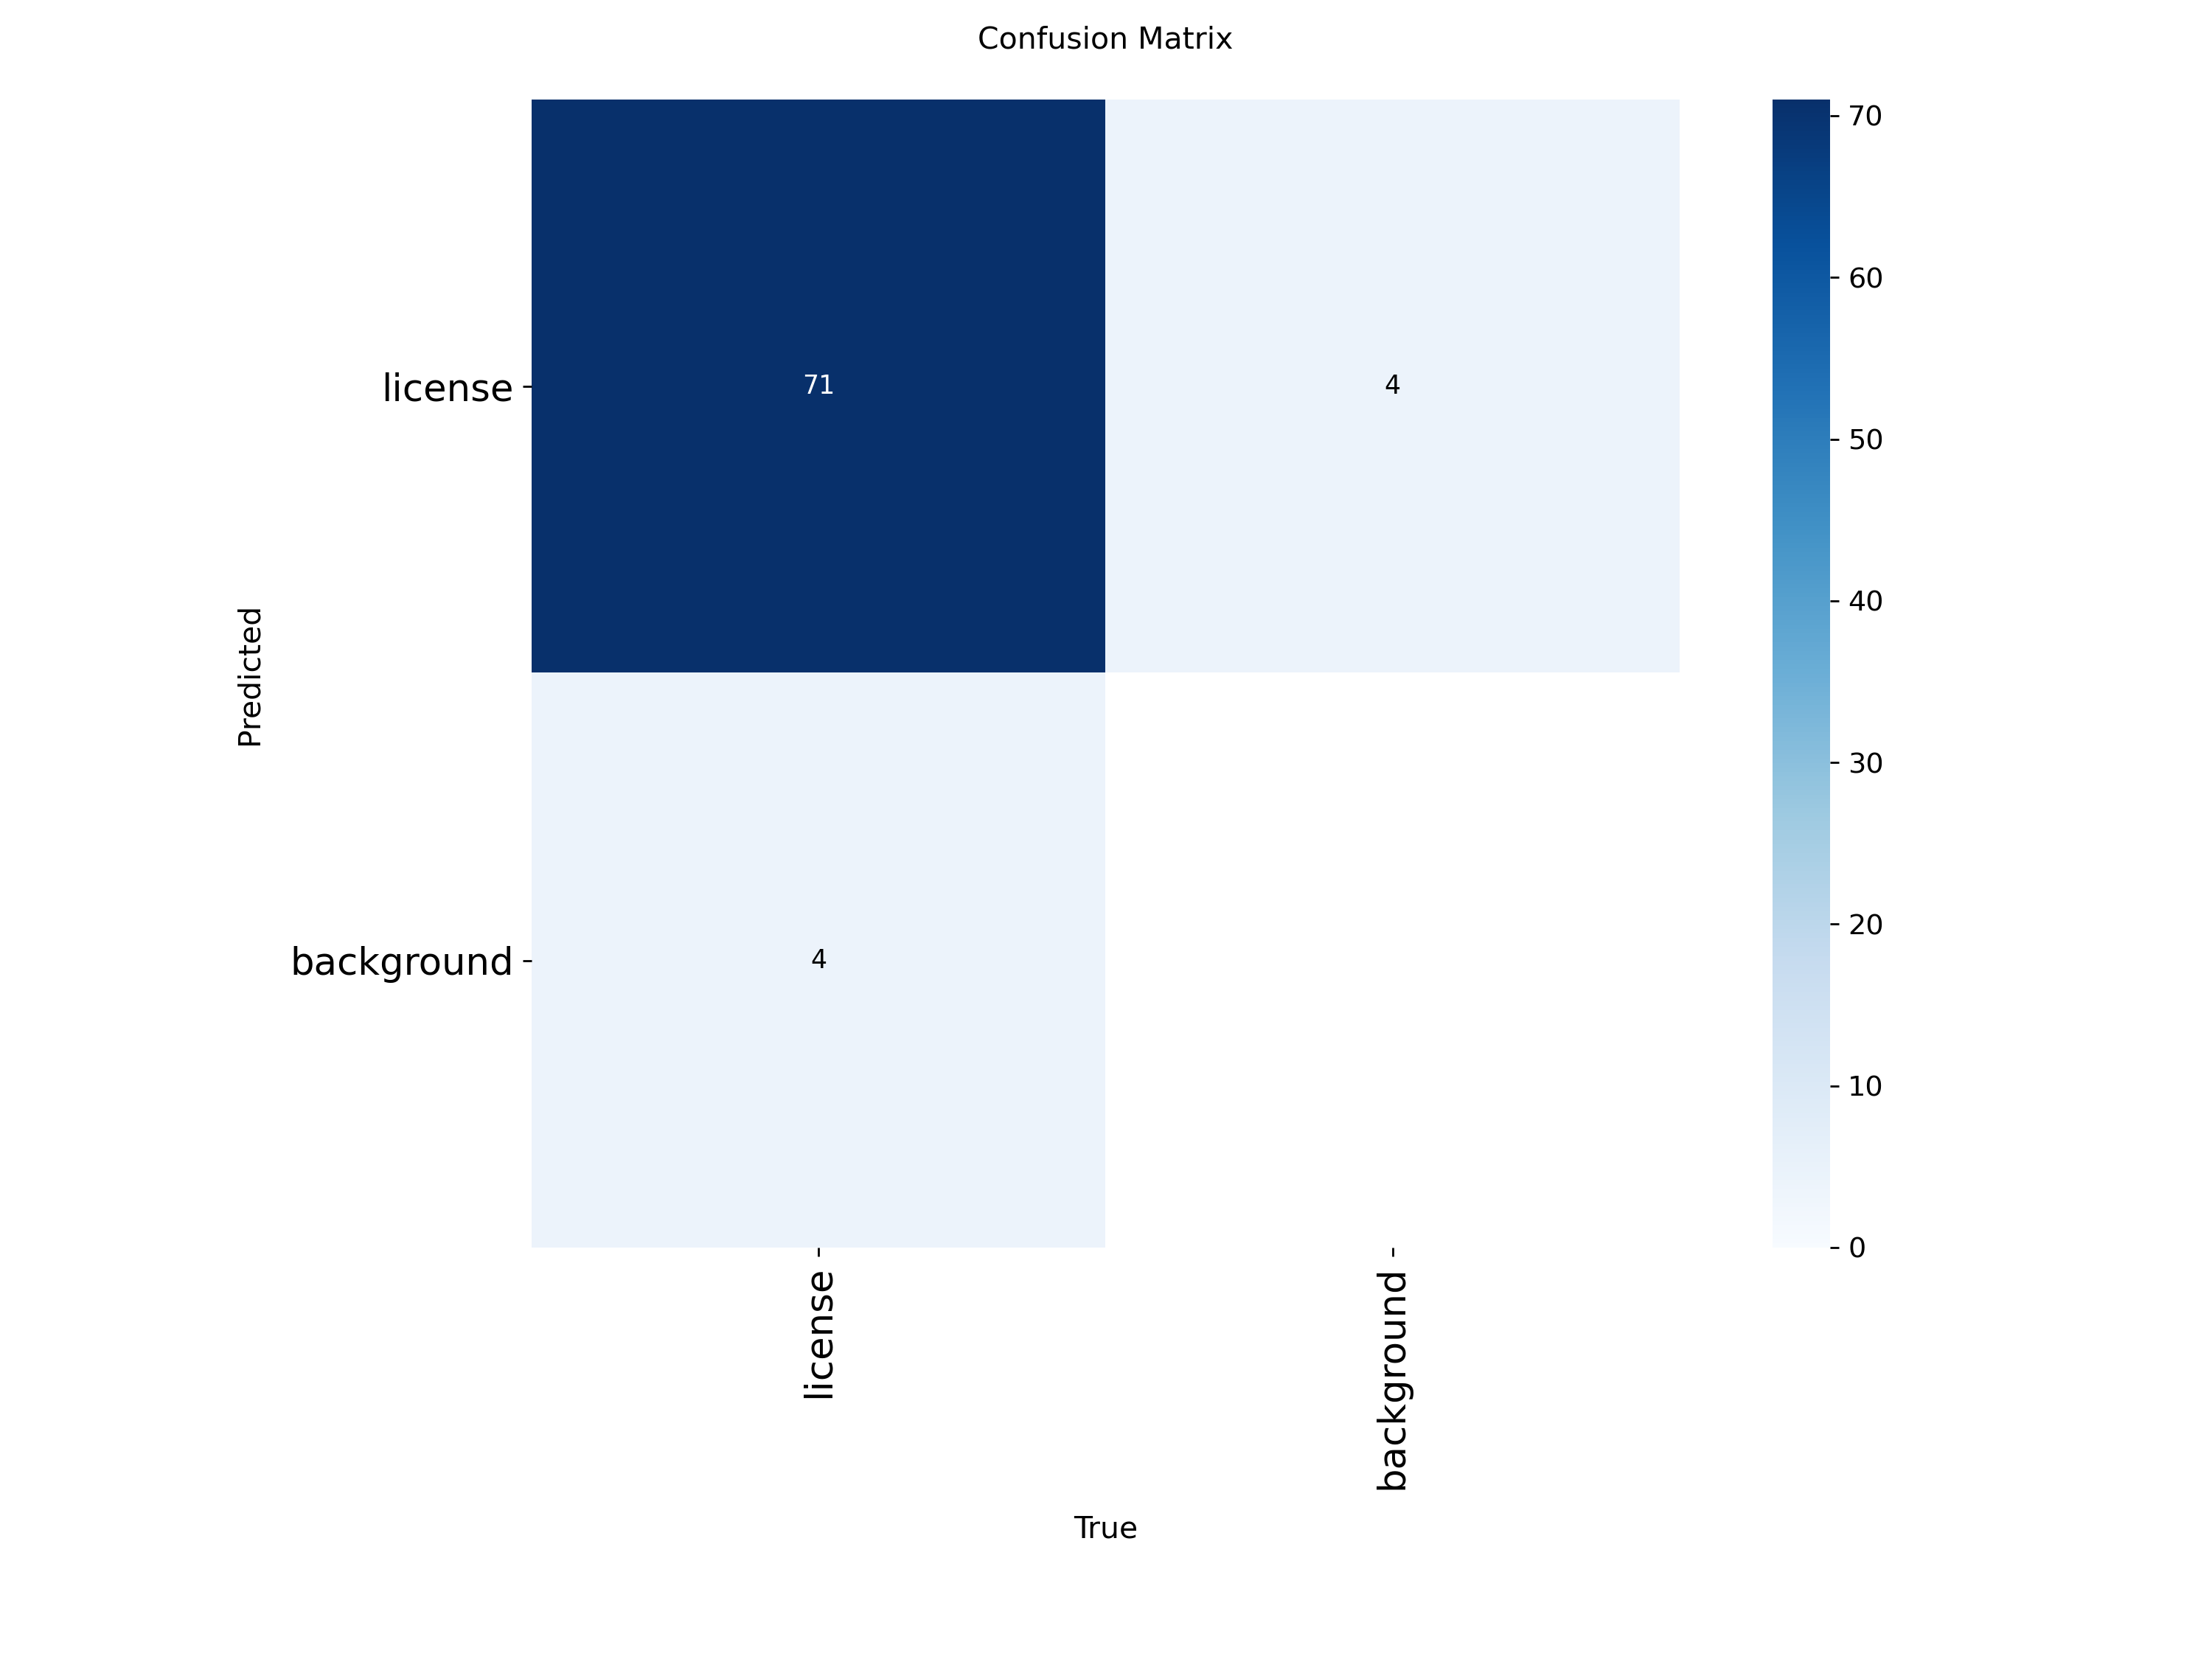

In [ ]:
from IPython.display import display, Image

Image(filename=f"{HOME}/runs/segment/train/confusion_matrix.png", width=600)

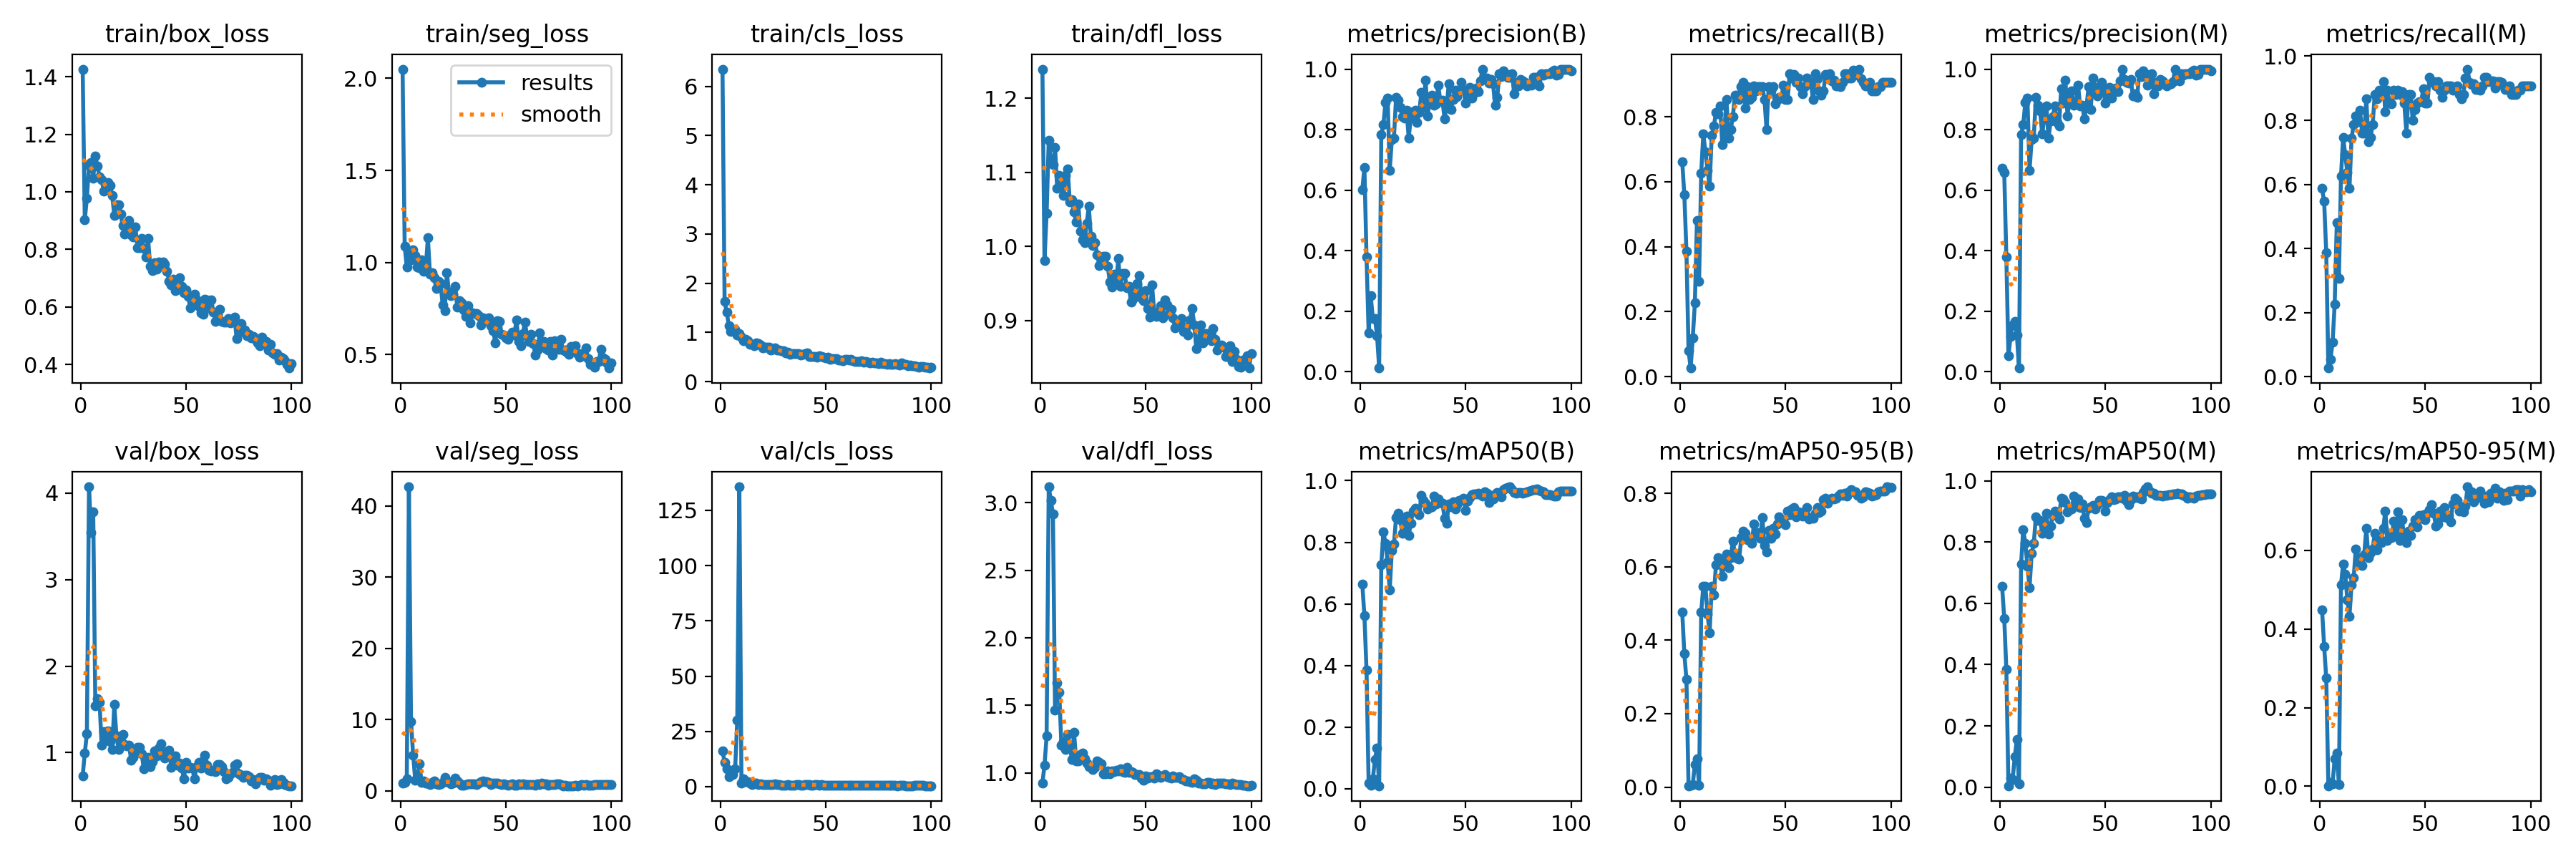

In [ ]:
Image(filename=f"{HOME}/runs/segment/train/results.png", width=600)

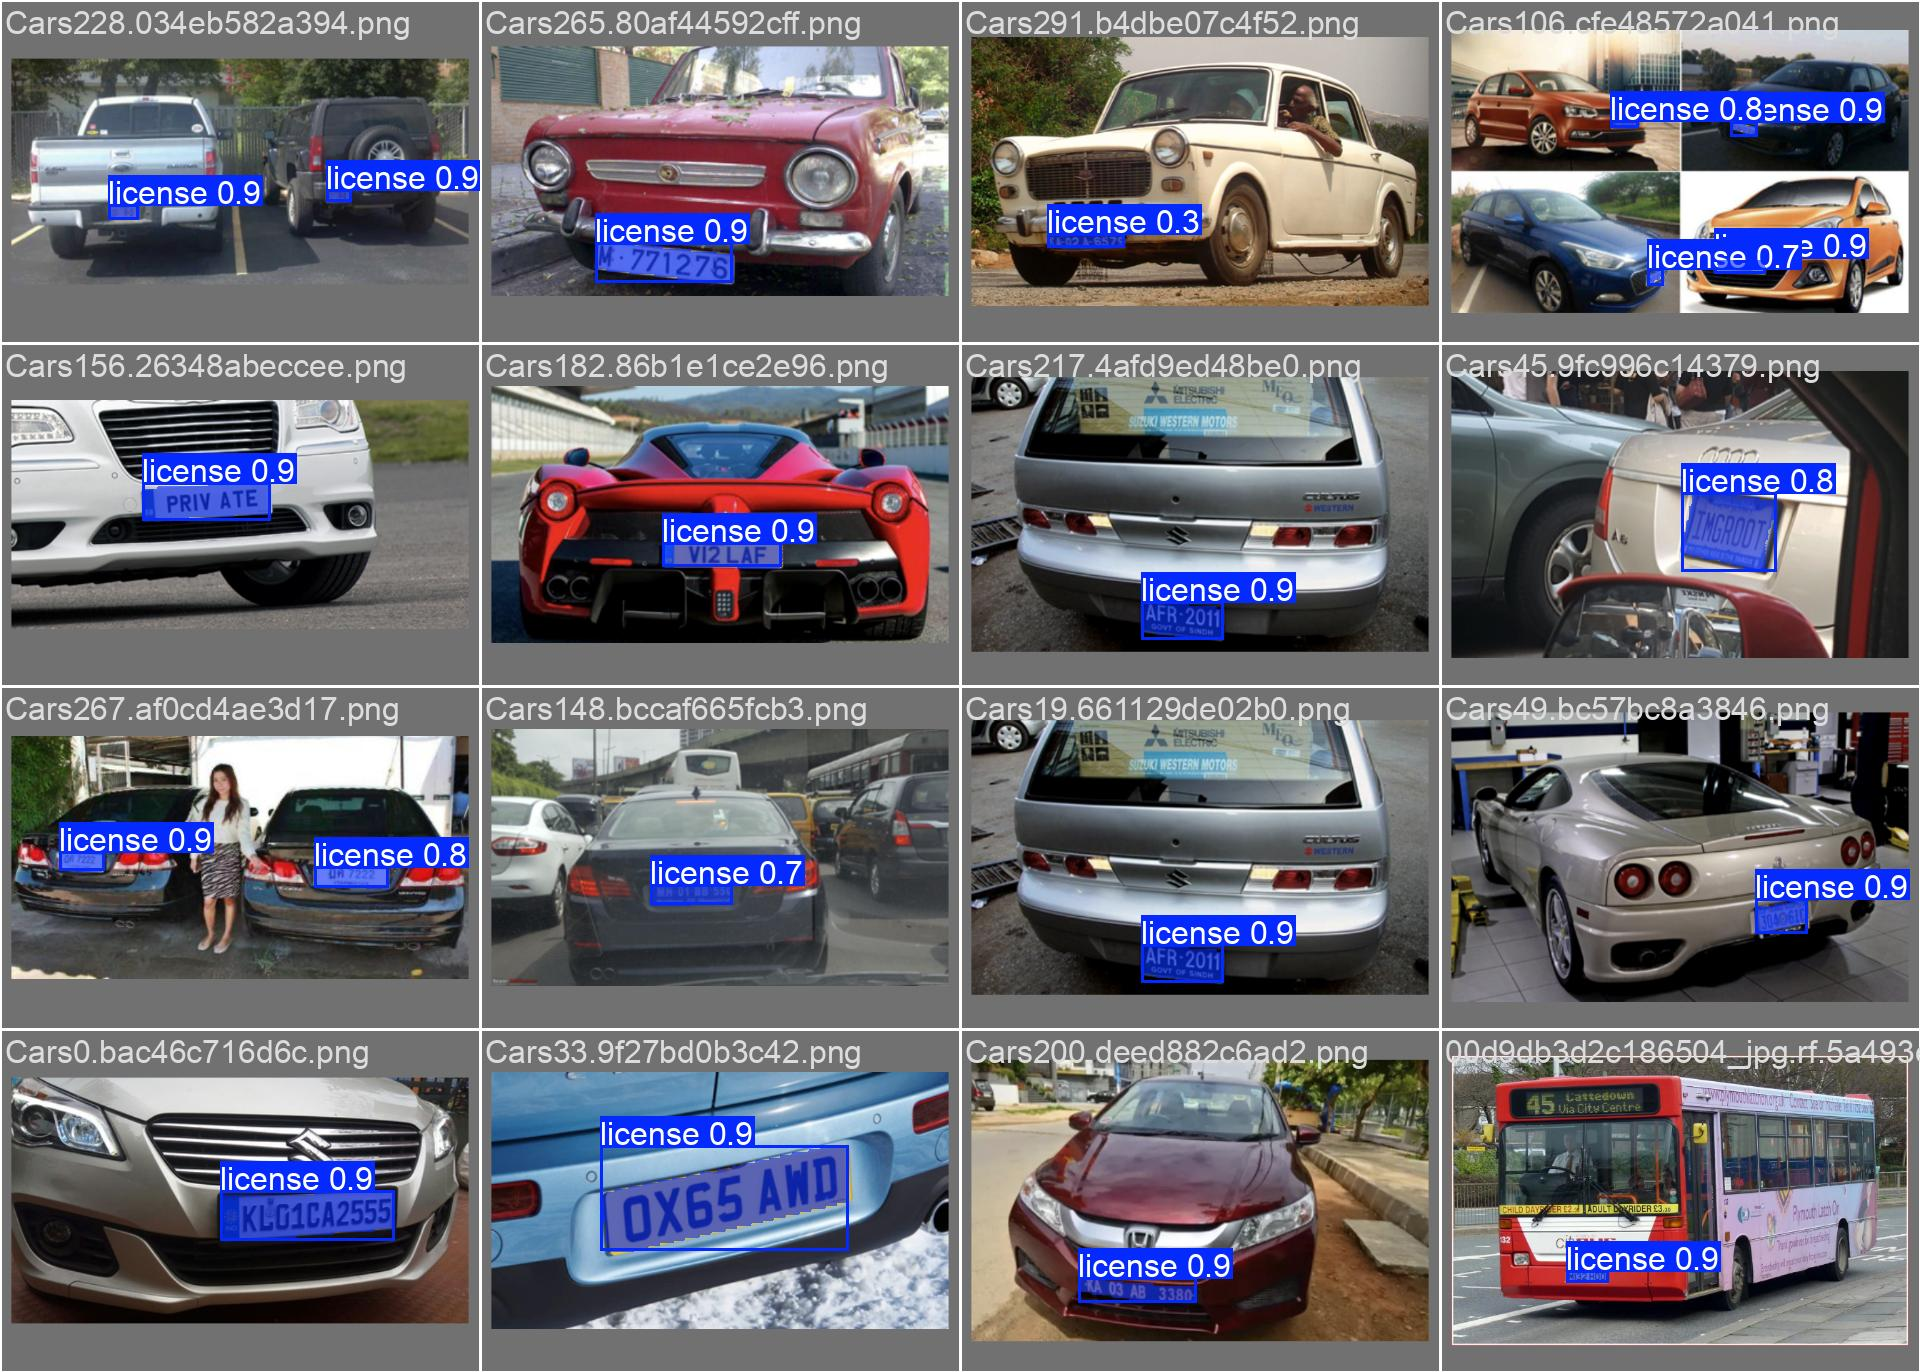

In [ ]:
Image(filename=f"{HOME}/runs/segment/train/val_batch0_pred.jpg", width=600)

# Validate the Model

You can use the YOLO CLI to validate the model on a validation set. This will give you the mAP score for the model.


In [ ]:
!yolo task=segment mode=val model={HOME}/runs/segment/train/weights/best.pt data=$yaml_path

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.197 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-seg summary (fused): 85 layers, 11,779,987 parameters, 0 gradients, 39.9 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3747.2±983.9 MB/s, size: 749.3 KB)
val: Scanning /content/number-plates-yolo-seg-1/valid/labels.cache... 65 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 65/65 1.2Mit/s 0.0s
val: /content/number-plates-yolo-seg-1/valid/images/cropquandoi73_jpg.rf.c07115b6eac99ebbd1dcae0525295355.0ea02de10ee2.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100

## Inference on the Test Set

You can use the YOLO CLI to run inference on the test set. This will give you the predictions for the test set and we can visualize them here.


In [ ]:
!yolo predict model={HOME}/runs/segment/train/weights/best.pt conf=0.25 source=$dataset_path/test/images save=True

Ultralytics 8.3.197 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-seg summary (fused): 85 layers, 11,779,987 parameters, 0 gradients, 39.9 GFLOPs

image 1/40 /content/number-plates-yolo-seg-1/test/images/0002a5b67e5f0909_jpg.rf.c8f81ef986e3e99af6f349c200080453.97c26fcaead7.jpg: 480x640 2 licenses, 53.2ms
image 2/40 /content/number-plates-yolo-seg-1/test/images/0010f4c10f7ab07e_jpg.rf.1844f6dde3b97ed1c762db933bbacaf3.d7246ef40eb7.jpg: 480x640 2 licenses, 16.5ms
image 3/40 /content/number-plates-yolo-seg-1/test/images/002d099996f3f443_jpg.rf.edb05fc406d0db3a30d19b526234e4ae.9f3f232f4e71.jpg: 480x640 (no detections), 16.4ms
image 4/40 /content/number-plates-yolo-seg-1/test/images/00c82d64185293a7_jpg.rf.6aaeb74faf1905eeee48dd4fb324e013.332ae3a4cf8a.jpg: 384x640 1 license, 54.5ms
image 5/40 /content/number-plates-yolo-seg-1/test/images/00e481ea1a520175_jpg.rf.c4d1a6e54a45b095e9656f64f44fbd74.8b1edfb54595.jpg: 480x640 1 license, 17.1ms
image 6/40 /content/number-pla

## Visualize the Predictions

Lets look at some of the predictions made by the model on the test set.


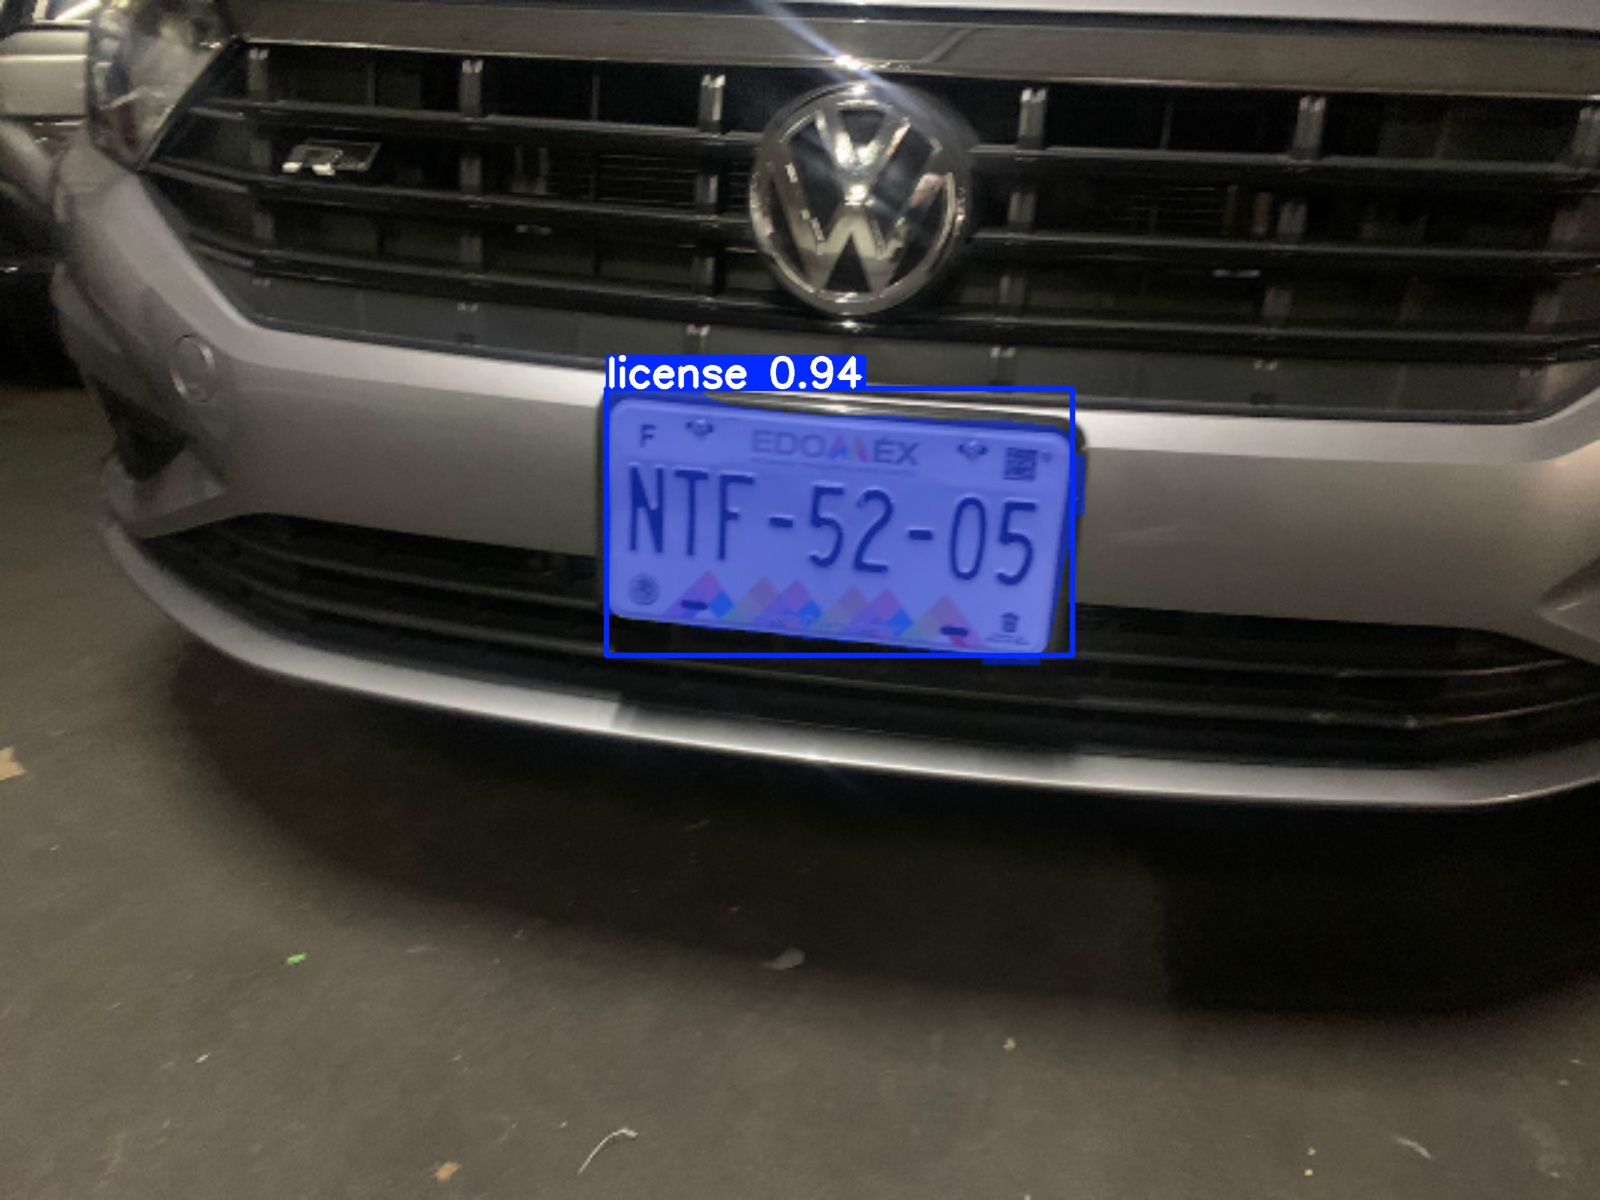

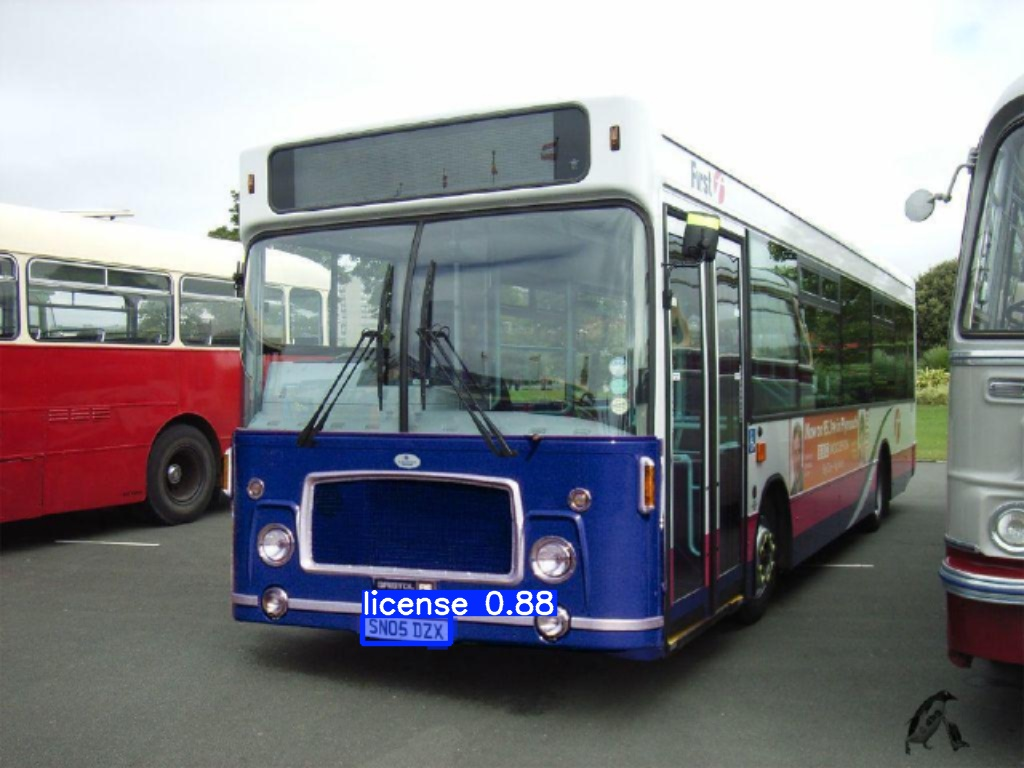

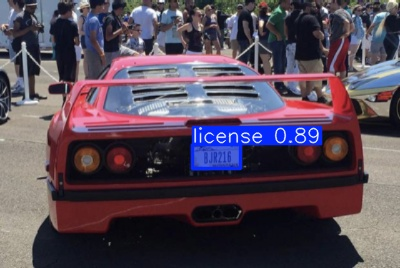

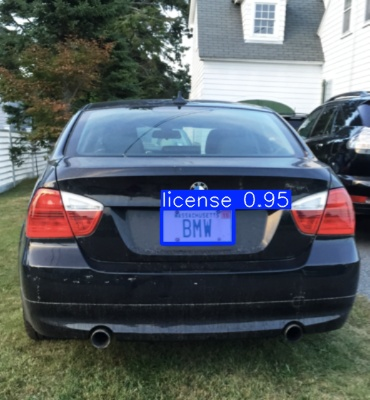

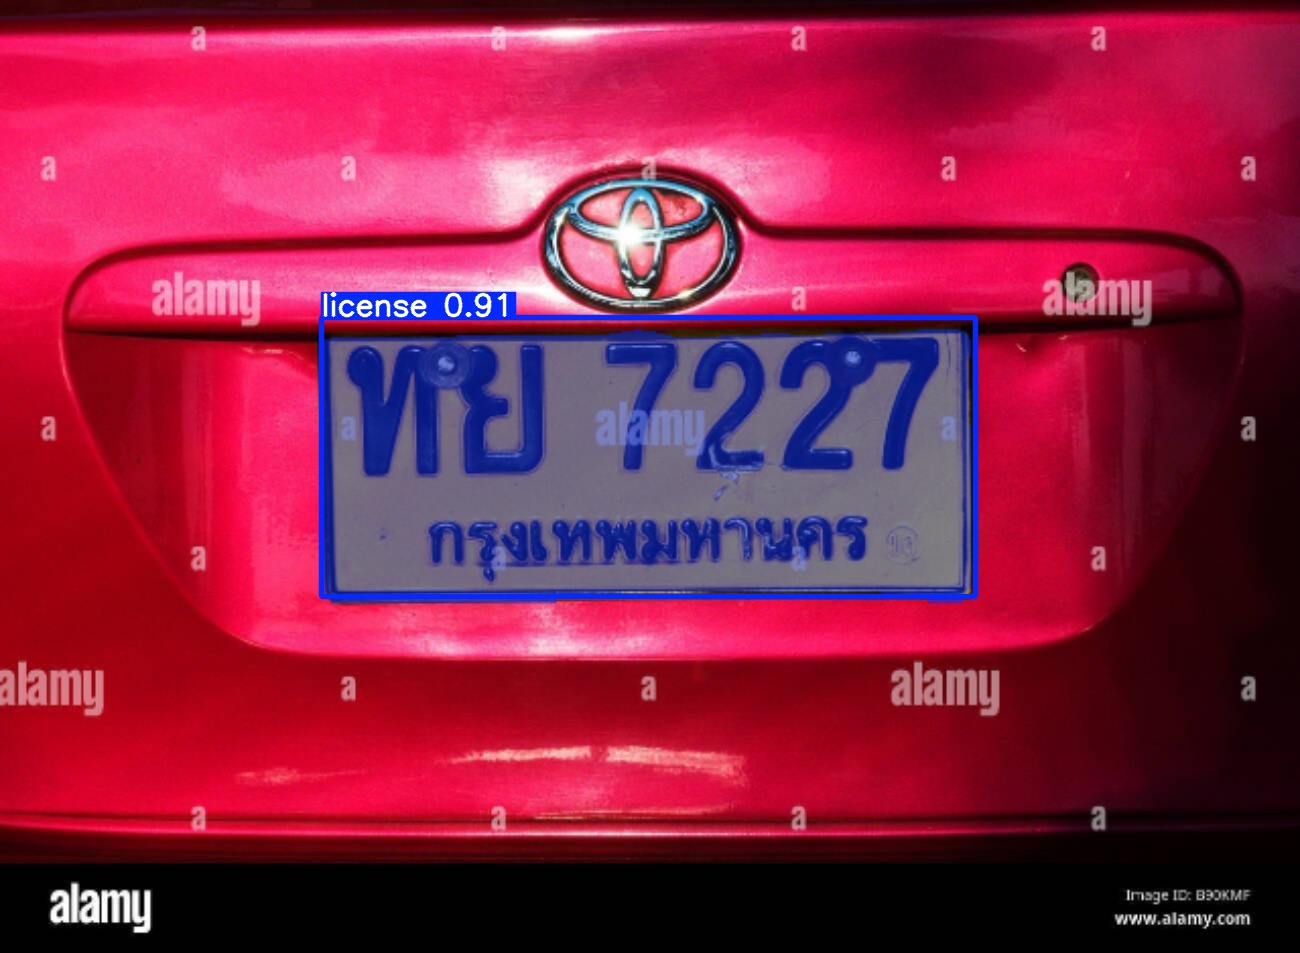

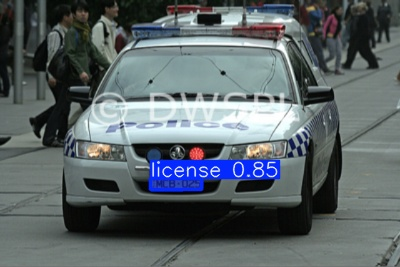

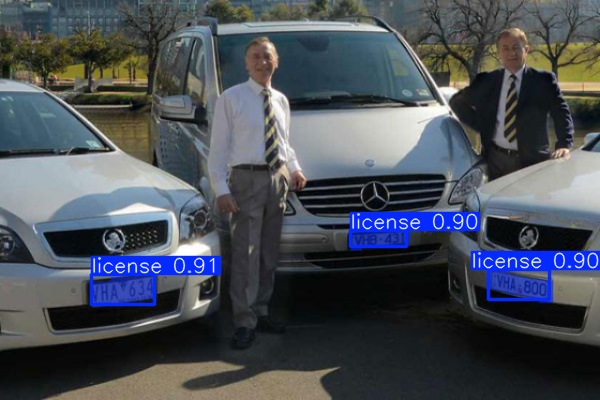

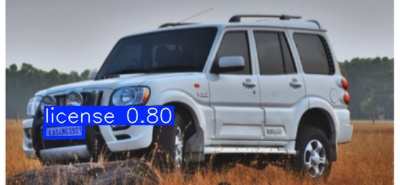

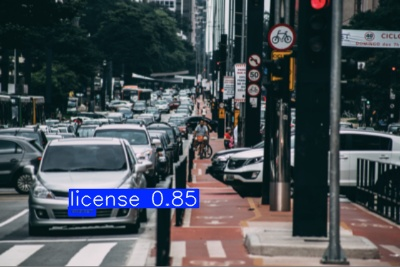

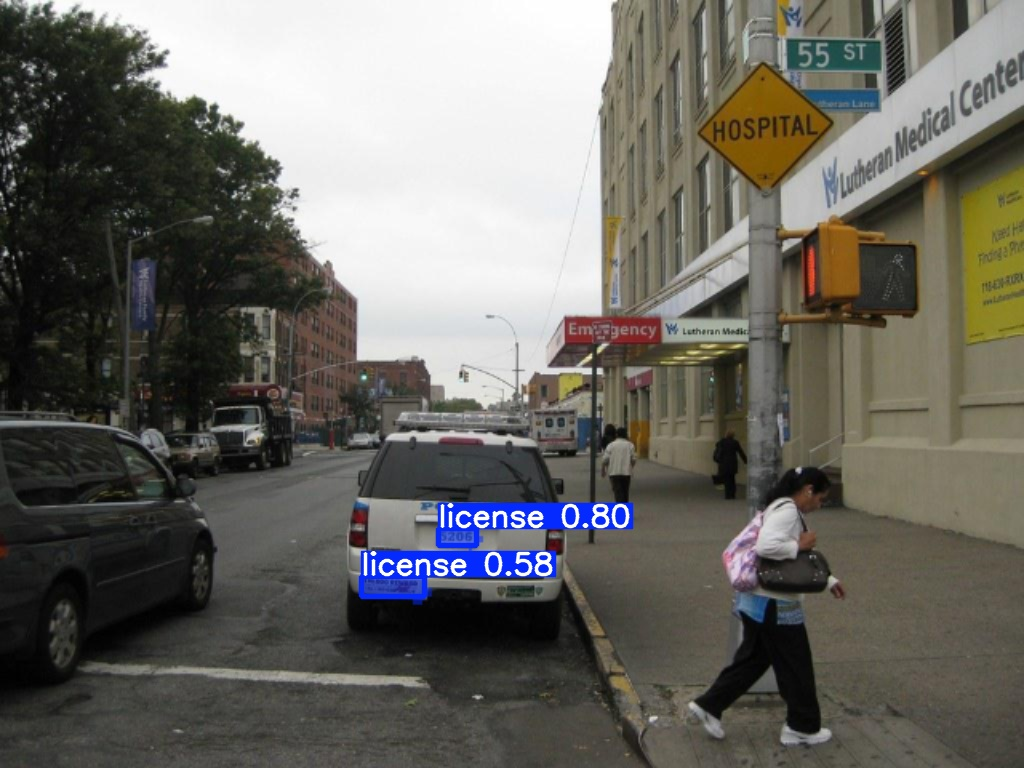

In [ ]:
import glob
import random

from IPython.display import Image, display

# Get all image paths
image_paths = glob.glob(f"{HOME}/runs/segment/predict/*.jpg")

# Select up to 20 random images
random_images = random.sample(image_paths, min(len(image_paths), 10))

# Display the selected images
for image_path in random_images:
    display(Image(filename=image_path, width=600))

## Conclusion

This notebook is a simple example of how to train a YOLOv8 segmentation model using the Ultralytics library. You can use this as a starting point for your own projects.

The model is trained on the exported dataset from Oslo and the results are visualized.

You can find the model weights and the training results in the `runs` folder. Generally `best.pt` is the best model and `results.png` gives you information on how the training went.
